# Reward curve figures for AmpC dataset

In [40]:
from pathlib import Path
import sys
from typing import Iterable

from matplotlib import pyplot as plt, patheffects as pe, ticker
import numpy as np
import seaborn as sns

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment
from scripts.utils import build_true_dict

sns.set_theme("talk", "white")

%matplotlib inline

def abbreviate_k_or_M(x: float, pos) -> str:
    if x >= 1e6:
        return f"{x*1e-6:0.1f}M"
    if x >= 1e3:
        return f"{x*1e-3:0.0f}k"

    return f"{x:0.0f}"

def pad_xss(xss: Iterable[Iterable]) -> np.ndarray:
    n = max(len(xs) for xs in xss)
    xss = [np.pad(xs, (0, n - len(xs)), constant_values=np.nan) for xs in xss]

    return np.array(xss, float)

def stack_curves(expts_dir: Path, top_k) -> np.ndarray:
    ys = []
    for p_exp in expts_dir.iterdir():
        e = Experiment(p_exp)
        ys.append(e.curve(top_k, "scores"))
    
    return pad_xss(ys)

def plot_curves(ax, Y, prune: bool = False):
    x = np.arange(Y.shape[1]) + 1

    y_mean = np.nanmean(Y, 0)
    y_sd = np.nanstd(Y, 0)

    ax.plot(
        x,
        y_mean,
        ls='dashed' if prune else 'solid',
        lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="pruning" if prune else "no pruning"
    )
    ax.fill_between(x, y_mean-y_sd, y_mean+y_sd, dashes=":", lw=1., ec="black", alpha=0.3)
    
    return ax

### Step 1: get the top-$k$ points for the datasets

In [2]:
hts_scores = build_true_dict(Path.home() / "molpal/data/EnamineHTS_scores.csv")
hts_top_1k = sorted(hts_scores.items(), key=lambda kv: kv[1], reverse=True)[:1000]

ampc_scores = build_true_dict(Path.home() / "molpal/data/AmpC_glide_scores_top200k.csv")
ampc_top_50k = sorted(ampc_scores.items(), key=lambda kv: kv[1], reverse=True)[:50000]

### Step 2: Calculate the reward curve for each run, collate them, and save them to a file

**NOTE:** This cell assumes you have your directories organized like so
```
ROOT_DIRECTORY
├── full
│   ├── 0.001
│   │   ├── rep-0 <-- output directory of a MolPAL run
│   │  ...
│   │   └── rep-N
│   ├── 0.002
│   └── 0.004
└── prune
    ├── 0.001
    ├── 0.002
    └── 0.004
```

In [ ]:
SPLITS =  ("0.001", "0.002", "0.004")
d_ampc = Path.home() / "active-projects/molpal-pruning/runs/ampc"

for split in SPLITS:
    Y_full = stack_curves(d_ampc / "full" / split, ampc_top_50k)
    Y_prune = stack_curves(d_ampc / "prune" / split, ampc_top_50k)

np.savez_compressed("ampc_reward_curves_full.npz", **dict(zip(SPLITS, Y_full)))
np.savez_compressed("ampc_reward_curves_prune.npz", **dict(zip(SPLITS, Y_prune)))

### Step 3: run the cell below and call the function with your desired dataset split

In [51]:
def make_ampc_reward_curve(split: str):
    sns.set_palette("dark")

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    full_npz = np.load("ampc_reward_curves_full.npz")
    prune_npz = np.load("ampc_reward_curves_prune.npz")

    Y_full = full_npz[split]
    Y_prune = prune_npz[split]

    plot_curves(ax, Y_full[:, :Y_prune.shape[1]], False)
    plot_curves(ax, Y_prune, True)

    mask = ~np.isnan(Y_prune)
    i_stop = np.argmin(mask, 1)
    i_stop = i_stop[i_stop > 0]
    if len(i_stop) > 0:
        ax.axvspan(i_stop.min(), Y_prune.shape[1], color="grey", alpha=0.2)

    ax.set_ylim(-0.05, 1.05)
    formatter = ticker.FuncFormatter(abbreviate_k_or_M)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(int(float(split)*100e6)))
    ax.tick_params(axis="x", which="major", bottom=True, rotation=20)

    ax.grid(True, ls="--")

    ax.set_xlabel("Molecules explored")
    ax.set_ylabel(f"Fraction of Top-50000 Scores Found")
    ax.legend()

    fig.tight_layout()

    return fig

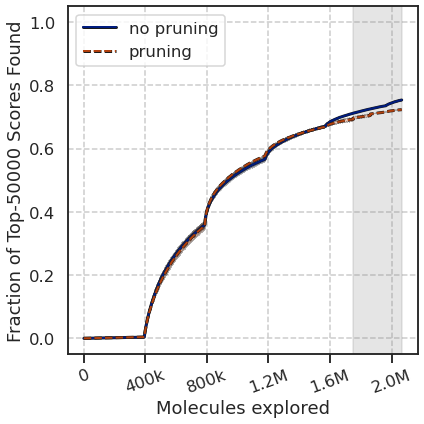

In [52]:
fig = make_ampc_reward_curve("0.004")

In [53]:
fig.savefig("../figures/ampc-004-curves.png", dpi=300)